<a href="https://colab.research.google.com/github/stevengregori92/CNN-Intro/blob/main/Training_with_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install "jcopdl<2.0"
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for jcopdl: filename=jcopdl-1.1.10-py2.py3-none-any.whl size=17913 sha256=de44d3392624cd2a3a780a76daf2e92a57be9f5e96d42ab40f720174bb7ee4cc
  Stored in directory: /root/.cache/pip/wheels/41/95/30/86345d2446be19c7d97dee789a2597bee81cfbb7b24a847f7c
Successfully built jcopdl
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
!gdown https://drive.google.com/uc?id=1JaxtqGlRpTXX9Rk8yTkY5dBF3zD5mnI0

Downloading...
From: https://drive.google.com/uc?id=1JaxtqGlRpTXX9Rk8yTkY5dBF3zD5mnI0
To: /content/Wea.zip
100% 615M/615M [00:04<00:00, 150MB/s]


In [5]:
!unzip /content/Wea.zip

Streaming output truncated to the last 5000 lines.
  inflating: weather/train/dew/2680.jpg  
  inflating: weather/train/dew/2681.jpg  
  inflating: weather/train/dew/2682.jpg  
  inflating: weather/train/dew/2683.jpg  
  inflating: weather/train/dew/2684.jpg  
  inflating: weather/train/dew/2685.jpg  
  inflating: weather/train/dew/2686.jpg  
  inflating: weather/train/dew/2687.jpg  
  inflating: weather/train/dew/2688.jpg  
  inflating: weather/train/dew/2689.jpg  
  inflating: weather/train/dew/2690.jpg  
  inflating: weather/train/dew/2691.jpg  
  inflating: weather/train/dew/2692.jpg  
  inflating: weather/train/dew/2693.jpg  
  inflating: weather/train/dew/2694.jpg  
  inflating: weather/train/dew/2695.jpg  
  inflating: weather/train/dew/2696.jpg  
  inflating: weather/train/dew/2697.jpg  
  inflating: weather/train/dew/2698.jpg  
  inflating: weather/train/dew/2699.jpg  
  inflating: weather/train/dew/2700.jpg  
  inflating: weather/train/dew/2701.jpg  
  inflating: weather/trai

#Dataset & Dataloader

In [6]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [7]:
bs = 128
crop_size = 64

train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(crop_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(70),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder('weather/train', transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle = True, num_workers=4)

test_set = datasets. ImageFolder('weather/test', transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle = True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [8]:
feature, target = next(iter(trainloader))
feature.shape

torch.Size([128, 3, 64, 64])

In [9]:
label2cat = train_set.classes
label2cat

['dew',
 'fogsmog',
 'frost',
 'glaze',
 'hail',
 'lightning',
 'rain',
 'rainbow',
 'rime',
 'sandstorm',
 'snow']

#Arsitektur & Config

In [10]:
from jcopdl.layers import conv_block, linear_block

In [11]:
nn.Conv2d(3,8,3,1,1)

Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [12]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv=nn.Sequential(
        conv_block(3, 8),
        conv_block(8, 16),
        conv_block(16, 32),
        conv_block(32, 64),
        nn.Flatten()
    )
    self.fc = nn.Sequential(
        linear_block(1024, 256, dropout=0.1),
        linear_block(256, 11, activation='lsoftmax')
    )

  def forward(self, x):
    x = self.conv(x)
    x = self.fc(x)
    return x

In [13]:
config = set_config({
    'batch_size': bs,
    'crop_size': crop_size
})

#Training Preparation

In [14]:
model = CNN().to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir='model')

#Training Loop include Acc

In [15]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == 'train':
        model.train()
    elif mode == 'test':
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device) # corrected line
        output = model(feature)
        loss = criterion(output, target)

        if mode == 'train':
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
        
    cost = cost/len(dataset)
    acc = correct/len(dataset)
    return cost, acc

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train:   0%|          | 0/42 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 2.1822 | Test_cost  = 2.2547 | Train_score = 0.2347 | Test_score = 0.2617 |


Train:   0%|          | 0/42 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 1.6609 | Test_cost  = 1.8914 | Train_score = 0.4461 | Test_score = 0.3805 |


Train:   0%|          | 0/42 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 1.4848 | Test_cost  = 1.7477 | Train_score = 0.5009 | Test_score = 0.4260 |


Train:   0%|          | 0/42 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 1.3672 | Test_cost  = 1.6281 | Train_score = 0.5406 | Test_score = 0.4494 |


Train:   0%|          | 0/42 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 1.2438 | Test_cost  = 1.5471 | Train_score = 0.5896 | Test_score = 0.4968 |


Train:   0%|          | 0/42 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 1.1765 | Test_cost  = 1.4164 | Train_score = 0.6024 | Test_score = 0.5325 |


Train:   0%|          | 0/42 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 1.1424 | Test_cost  = 1.5019 | Train_score = 0.6159 | Test_score = 0.4909 |
==> EarlyStop patience =  1 | Best test_score: 0.5325


Train:   0%|          | 0/42 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 1.1416 | Test_cost  = 1.3065 | Train_score = 0.6208 | Test_score = 0.5753 |


Train:   0%|          | 0/42 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 1.0747 | Test_cost  = 1.2968 | Train_score = 0.6364 | Test_score = 0.5831 |


Train:   0%|          | 0/42 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 1.0516 | Test_cost  = 1.2930 | Train_score = 0.6434 | Test_score = 0.5662 |
==> EarlyStop patience =  1 | Best test_score: 0.5831


Train:   0%|          | 0/42 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 1.0514 | Test_cost  = 1.3201 | Train_score = 0.6379 | Test_score = 0.5604 |
==> EarlyStop patience =  2 | Best test_score: 0.5831


Train:   0%|          | 0/42 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 1.0307 | Test_cost  = 1.2670 | Train_score = 0.6451 | Test_score = 0.5792 |
==> EarlyStop patience =  3 | Best test_score: 0.5831


Train:   0%|          | 0/42 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 1.0106 | Test_cost  = 1.3104 | Train_score = 0.6545 | Test_score = 0.5643 |
==> EarlyStop patience =  4 | Best test_score: 0.5831


Train:   0%|          | 0/42 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 1.0143 | Test_cost  = 1.2548 | Train_score = 0.6511 | Test_score = 0.5825 |
==> EarlyStop patience =  5 | Best test_score: 0.5831
==> Execute Early Stopping at epoch: 14 | Best test_score: 0.5831
==> Best model is saved at model


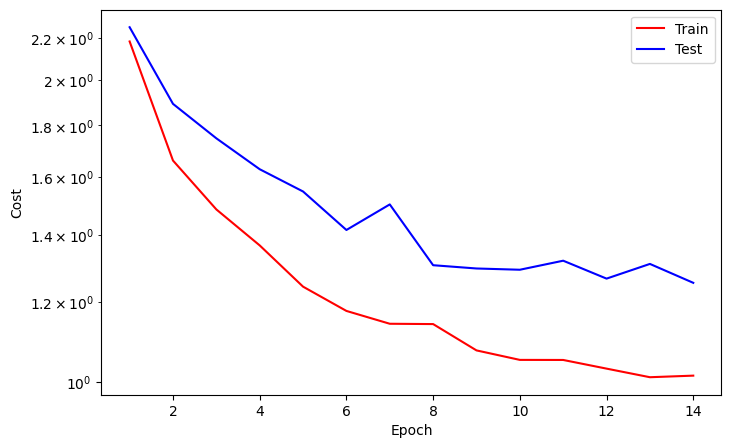

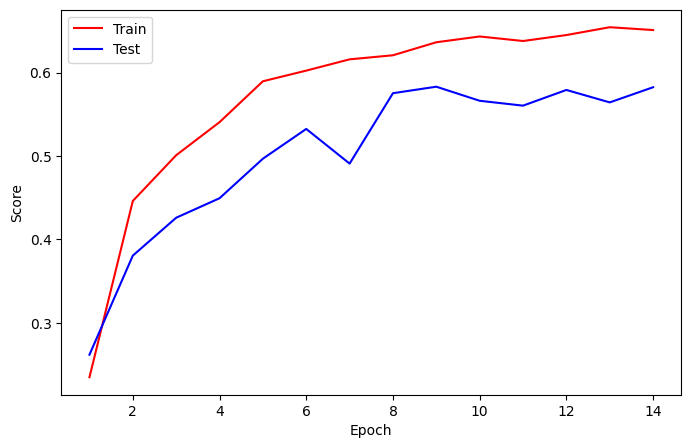

In [16]:
while True:
  train_cost, train_score = loop_fn('train', train_set, trainloader, model, criterion, optimizer, device)
  with torch.no_grad():
      test_cost, test_score = loop_fn('test', test_set, testloader, model, criterion, optimizer, device)

  #Logging
  callback.log(train_cost, test_cost, train_score, test_score)

  #Checkpoint
  callback.save_checkpoint()

  #Runtime Plotting
  callback.cost_runtime_plotting()
  callback.score_runtime_plotting()

  #Early Stopping
  if callback.early_stopping(model, monitor='test_score'):
    callback.plot_cost()
    callback.plot_score()
    break

#Predict

In [17]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [19]:
with torch.no_grad():
  model.eval()
  output = model(feature)
  preds = output.argmax(1)
preds

tensor([ 9,  4,  0,  4,  2,  1,  1,  1,  8, 10,  8,  5,  4,  5,  5,  0,  5,  8,
         8,  8,  8,  4,  8,  2, 10,  1,  3,  8,  5,  9,  0,  8,  9,  1,  0,  8,
         1,  2,  3,  3,  1,  9,  8,  1,  3, 10,  3,  2,  3,  8,  9,  9,  1,  1,
         5,  8,  4,  8,  6,  4,  5,  5,  8,  6, 10,  6,  0,  8,  3,  2,  3,  6,
         4, 10,  6,  1,  5,  0,  6,  3,  9,  1,  8,  9,  2,  1,  3,  4,  3,  1,
         6,  6, 10,  1,  5, 10,  8, 10,  3,  9,  0,  6,  5,  1,  6, 10,  6, 10,
         8,  1,  9,  2,  6,  5, 10,  8,  8, 10,  8,  1,  5,  1,  8, 10,  8, 10,
         8,  5])

#Visualize

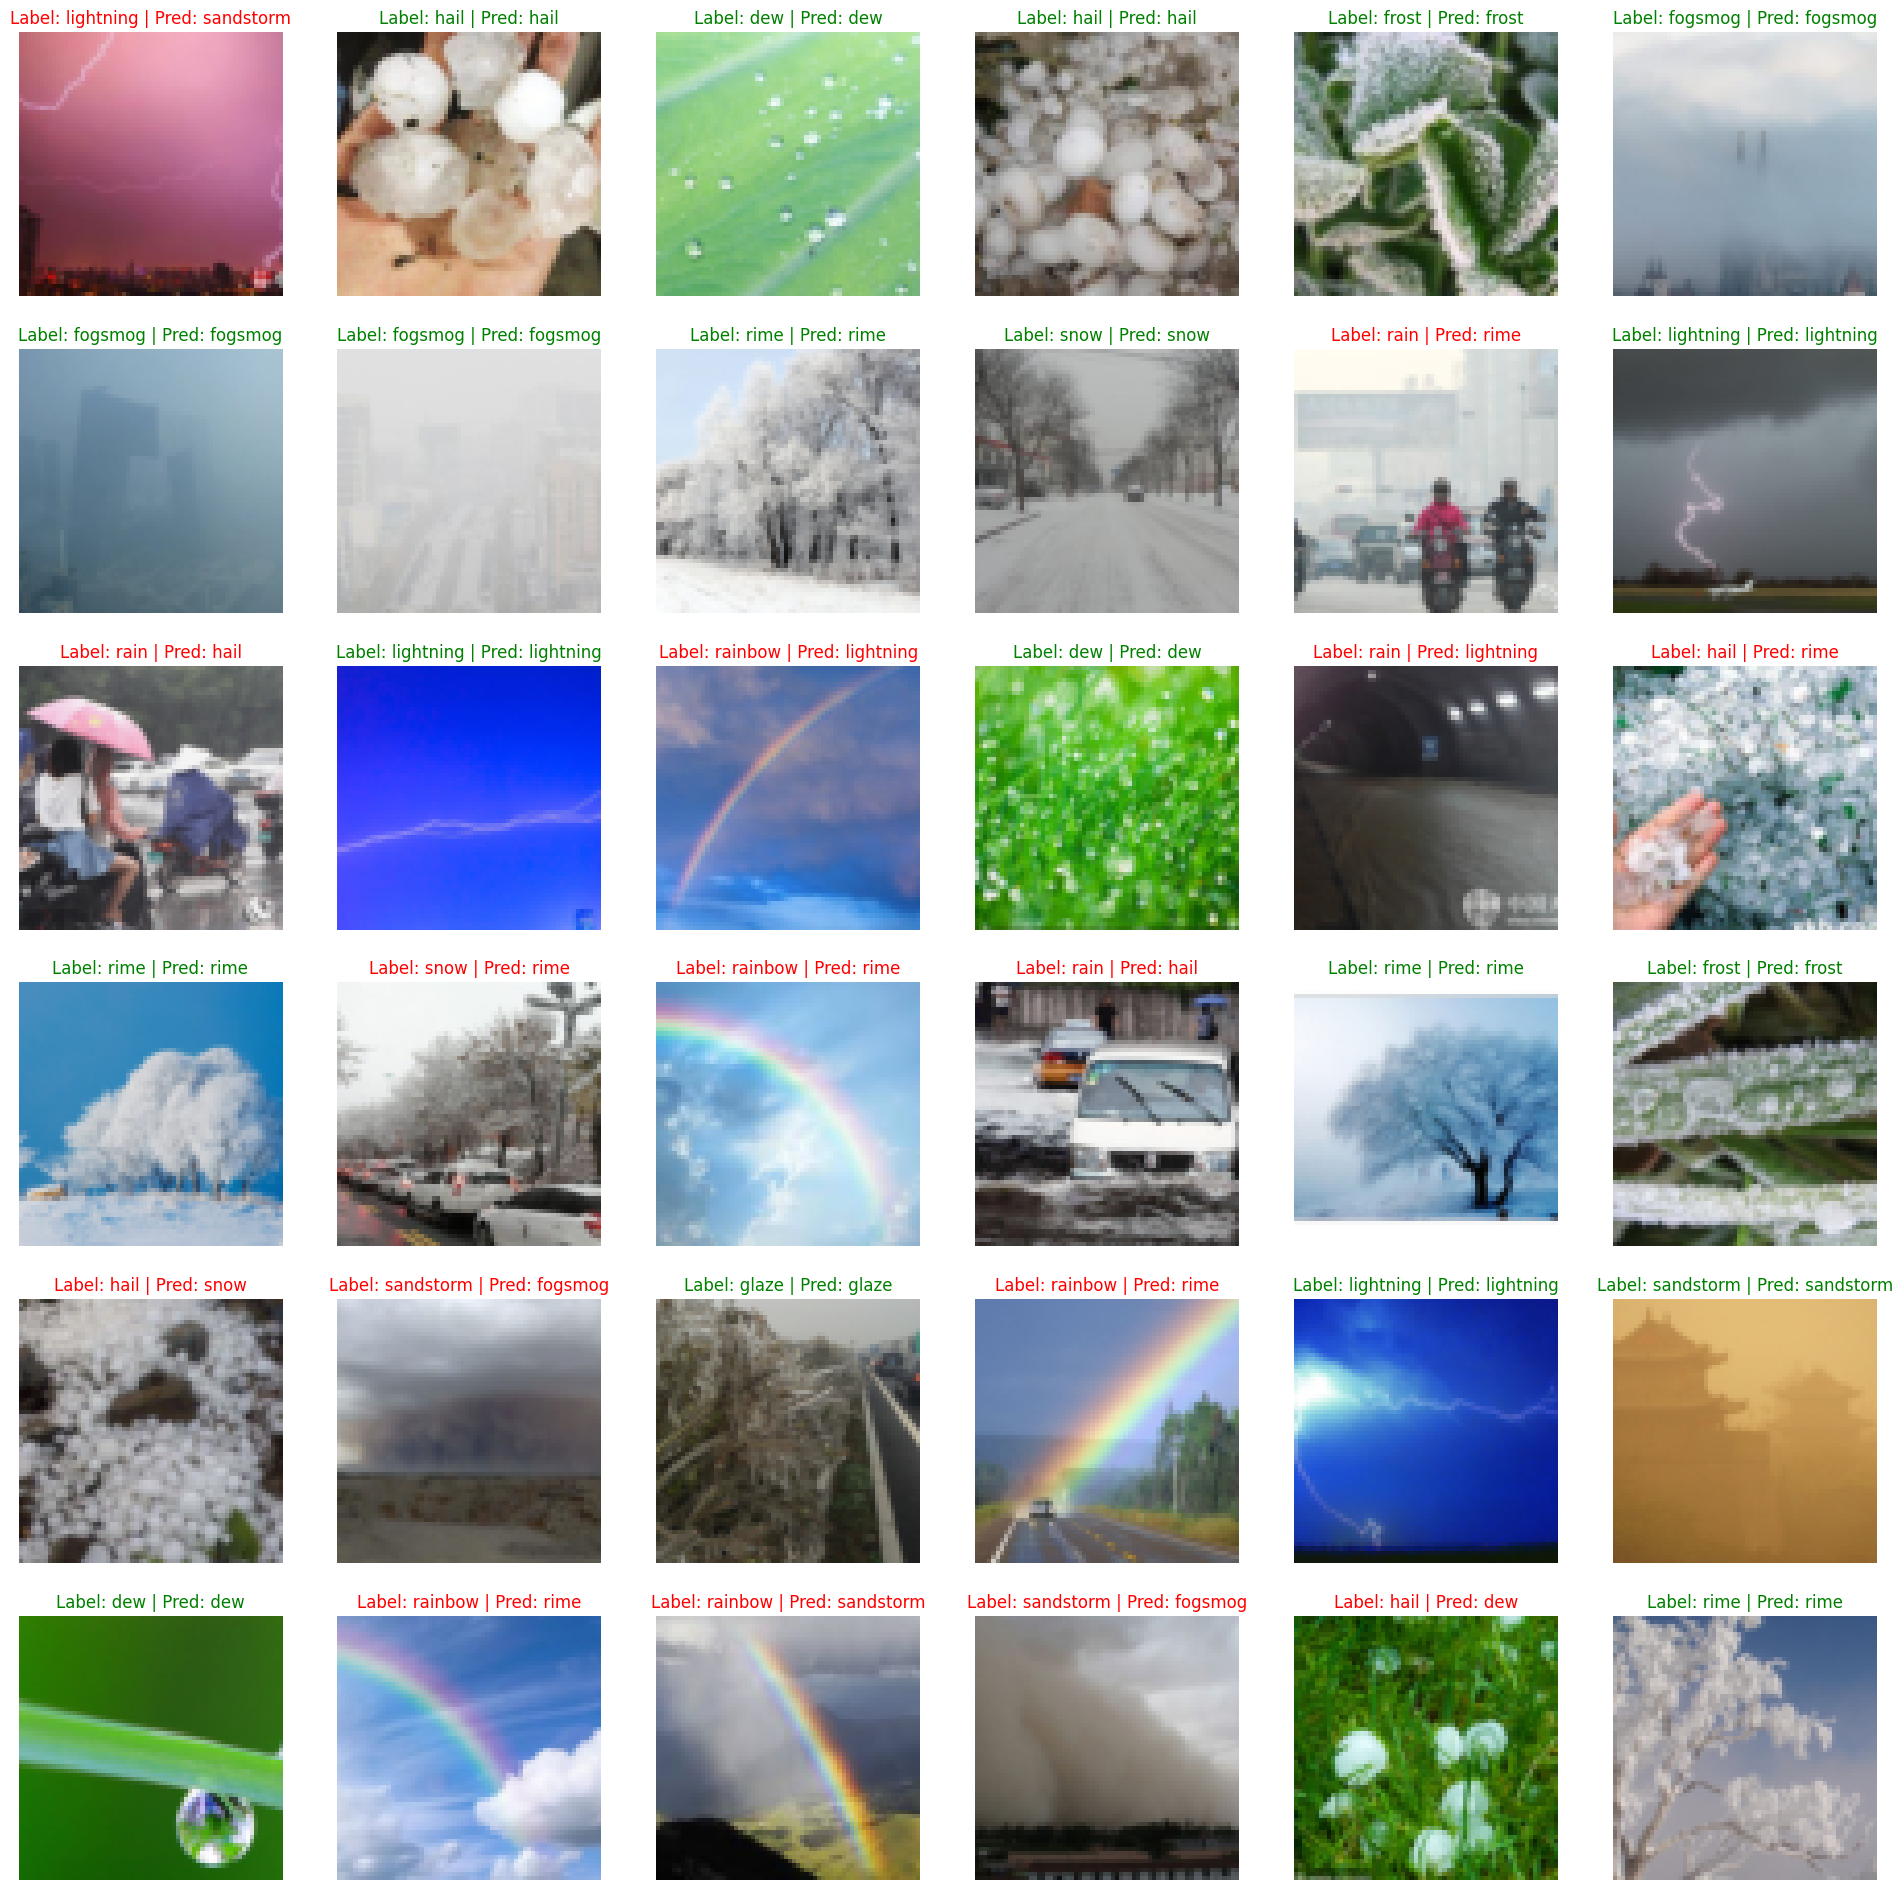

In [20]:
fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for image, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(image.permute(1, 2, 0).cpu())
    font = {'color': 'r'} if label.item() != pred.item() else {'color': 'g'}
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f'Label: {label} | Pred: {pred}', fontdict=font)
    ax.axis('off')

plt.show()
